In [2]:
import pandas as pd

In [3]:
df=pd.read_parquet("/Users/rmeskarian/Projects/ml-pipeline-development/example/predict_next_day_usage/data/sk_synthetic_data_window21_asset_1.parquet")

In [5]:
df.head()

,prediction_date,I_0,I_1,I_2,I_3,I_4,N_0,N_1,N_2,N_3,N_4,target,evaluation_date
0,1997-12-31,0.423717,-1.247574,0.398687,-1.203704,-0.611467,-0.047182,-1.473742,0.709151,1.434623,-0.251466,116.924968,1998-02-02
1,1998-01-02,-1.536124,1.118155,1.013823,-0.797659,0.559431,1.065911,-0.431148,1.494710,-0.550735,-0.226867,-129.943721,1998-02-03
2,1998-01-05,0.286904,-0.945616,0.520041,-0.370704,0.449712,-0.067276,0.317161,-1.318396,0.225609,-2.320594,-74.339045,1998-02-04
3,1998-01-06,-0.887487,0.032037,0.091198,0.480244,-1.868182,-0.076098,-0.196867,-0.780597,-0.887304,-0.896464,-185.580065,1998-02-05
4,1998-01-07,-0.604302,0.366675,1.016549,-0.898869,-0.734339,-0.606337,-0.308624,-1.827345,0.227137,1.786522,130.836614,1998-02-06


In [7]:
df.prediction_date.max()

Timestamp('2022-06-06 00:00:00')

In [35]:
df=pd.read_parquet("/Users/rmeskarian/Projects/ml-pipeline-development/example/predict_next_day_usage/data/df_processed_662171.parquet")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rmeskarian/Projects/ml-pipeline-development/example/predict_next_day_usage/data/df_processed_662171.parquet'

In [20]:
import pandas as pd
import calendar

def create_monthly_target(df):
    """
    1. Creates an evaluation_date column as the last day of the month for each prediction_date
    2. Creates a target column where all days in a month have the target value from the end-of-month
    3. Handles multiple org_ids separately
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'prediction_date', 'org_id', and 'billable_usage' columns
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with new 'evaluation_date' and 'monthly_target' columns
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()
    
    # Make sure prediction_date is datetime
    result_df['prediction_date'] = pd.to_datetime(result_df['prediction_date'])
    
    # Create evaluation_date as the last day of each month
    def last_day_of_month(date):
        last_day = calendar.monthrange(date.year, date.month)[1]
        return pd.Timestamp(date.year, date.month, last_day)
    
    result_df['evaluation_date'] = result_df['prediction_date'].apply(last_day_of_month)
    
    # Extract month-year for grouping
    result_df['month_year'] = result_df['prediction_date'].dt.to_period('M')
    
    # Find the end-of-month target values for each org_id
    # These are rows where prediction_date equals evaluation_date
    eom_targets = result_df[result_df['prediction_date'] == result_df['evaluation_date']]
    eom_targets = eom_targets[['org_id', 'month_year', 'billable_usage']]
    
    # Rename for clarity in the merge
    eom_targets = eom_targets.rename(columns={'billable_usage': 'monthly_target'})
    
    # Merge the end-of-month targets back to the original dataframe
    result_df = result_df.merge(eom_targets, on=['org_id', 'month_year'], how='left')
    
    # Drop the temporary month_year column
    result_df = result_df.drop(columns=['month_year'])
    
    return result_df

In [34]:
df_with_target = create_monthly_target(df)
# Drop billable_usage column
df_with_target = df_with_target.drop(columns=['billable_usage', 'year', 'month', 'week_of_year','days_in_month', 'month_sin'])

# Save to parquet file
df_with_target.to_parquet('/Users/rmeskarian/Projects/ml-pipeline-development/example/predict_next_day_usage/data/df_post_processed_662171.parquet')


In [23]:
df_with_target[df_with_target["prediction_date"]=="2023-07-26"]

,org_id,prediction_date,billable_usage,hg_lag1,hl-retention_lag1,year,month,quarter,day_of_week,day_of_month,...,ratio_to_3_months_ago,value_6_months_ago,ratio_to_6_months_ago,value_12_months_ago,ratio_to_12_months_ago,org_type_Contracted,org_type_Self-Serve Advanced,org_type_Self-Serve Pro,evaluation_date,monthly_target
302,662171,2023-07-26,9.219714,2.0,8.848851,2023,7,3,2,26,...,0.950918,9.774359,0.943255,0.0,0.0,0,0,1,2023-07-31,11.016335


In [31]:
predictions_df = pd.read_pickle("/Users/rmeskarian/Projects/ml-pipeline-development/outputs/predict_next_day_usage_None_regression_2025_Mar-05/lasso_regressor_PurgedWalkForwardCV_RandomizedSearchCV_NoneD_2025_Mar-05_10-50-13/historicalpredictions.pkl")
predictions_df.head()


,prediction_date,evaluation_date,monthly_target,predicted_target
302,2023-07-26,2023-07-31,11.016335,11.009783
303,2023-07-27,2023-07-31,11.016335,11.011101
304,2023-07-28,2023-07-31,11.016335,11.017637
305,2023-07-29,2023-07-31,11.016335,11.021268
306,2023-07-30,2023-07-31,11.016335,11.024096


In [32]:
from sklearn.metrics import r2_score

r2 = r2_score(predictions_df['monthly_target'], predictions_df['predicted_target'])
print(f"R-squared score: {r2:.4f}")


R-squared score: -75.1014


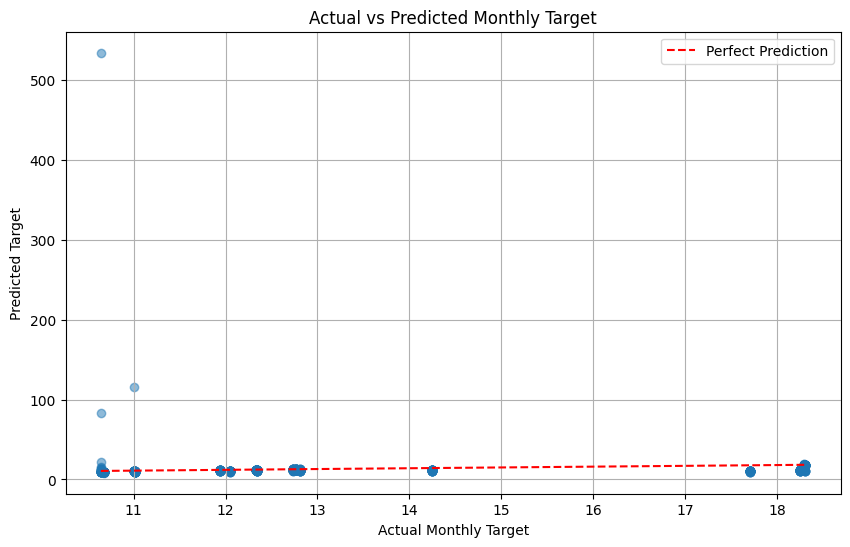

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['monthly_target'], predictions_df['predicted_target'], alpha=0.5)
plt.plot([predictions_df['monthly_target'].min(), predictions_df['monthly_target'].max()], 
         [predictions_df['monthly_target'].min(), predictions_df['monthly_target'].max()], 
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Monthly Target')
plt.ylabel('Predicted Target')
plt.title('Actual vs Predicted Monthly Target')
plt.legend()
plt.grid(True)
plt.show()
